# Предисловие

* В Ноутбуке реализована нейросеть предложенная составителями задачи - Convolution -> BiLSTM -> Classifier
* Для обучения используетс CTC Loss, AdamW и ReduceLROnPlateau
* Я не разносил ноутбук на модули для удобства проверяющих (всё в одном месте)

In [2]:
!pip install -r requirements.txt 

  Using cached torchvision-0.14.1-cp310-cp310-manylinux1_x86_64.whl (24.2 MB)
  Using cached torchmetrics-0.11.0-py3-none-any.whl (512 kB)


In [1]:
import shutil
import os

import numpy as np
import torchvision
import torch
from torch import nn
from torchvision import transforms as T

import torchmetrics
from sklearn.metrics import accuracy_score

from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
path_to_files = 'CCPD2019-dl1/'

# EDA

In [3]:
from collections import Counter

labels = list("".join([label.split("-")[1].split(".")[0] for label in  os.listdir(f"{path_to_files}/train")]))
counter = Counter(labels)
dict(counter)

{'皖': 191796,
 'A': 196677,
 'W': 13531,
 '7': 68163,
 '3': 63947,
 'G': 13634,
 '6': 78174,
 '8': 79681,
 '9': 77936,
 'V': 11021,
 'D': 14776,
 '2': 71020,
 'F': 14121,
 '0': 76983,
 'M': 14862,
 'L': 17186,
 '5': 69590,
 'B': 13288,
 'T': 12616,
 '苏': 3311,
 'U': 11079,
 'H': 17089,
 '1': 73544,
 'Z': 15297,
 '4': 27365,
 'X': 15169,
 'R': 12533,
 'K': 13030,
 'J': 14582,
 'Y': 16875,
 'P': 11468,
 'N': 13690,
 'E': 12290,
 'C': 16472,
 'Q': 6978,
 '豫': 431,
 'S': 15212,
 '赣': 151,
 '甘': 18,
 '京': 307,
 '湘': 96,
 '粤': 373,
 '浙': 1349,
 '沪': 663,
 '川': 121,
 '津': 60,
 '晋': 67,
 '冀': 175,
 '闽': 208,
 '鄂': 278,
 '辽': 59,
 '鲁': 248,
 '贵': 16,
 '渝': 74,
 '云': 17,
 '桂': 15,
 '吉': 13,
 '陕': 55,
 '黑': 18,
 '蒙': 19,
 '青': 11,
 '宁': 5,
 '琼': 9,
 '新': 16,
 'O': 1,
 '藏': 1}

После краткого анализа данных, видим явный дизбаланс класов

# Preprocessing

In [4]:
train_transform = T.Compose([
    T.Resize((32, 200)),
    T.RandomGrayscale(0.5),
    T.RandomRotation(0.2),
    T.ColorJitter(),
    T.GaussianBlur(kernel_size=(5, 5)),
    T.ToTensor(),
])

test_transform = T.Compose([
    T.Resize((32, 200)),
    T.ToTensor(),
])

In [5]:
unk_token = '<UNK>'
blank_token = '<BLANK>'

In [6]:
class Tokenizer:
    def __init__(self, labels):
        self.char2id = {}
        self.char2id[unk_token] = 0
        self.char2id[blank_token] = 1
        
        for i, label in enumerate(labels):
                self.char2id[label] = i + 2
                
        self.id2char = {v:k for k, v in self.char2id.items()}
        
    def encode(self, label):
        enc_label = [self.char2id[char] if char in self.char2id else self.char2id[unk_token] for char in label]
        return enc_label
    
    def __len__(self):
        return len(self.char2id)
    
    def decode(self, enc_list):
        decoded_list = ''
        for i, char in enumerate(enc_list):
            if (char != self.char2id[unk_token] and char != self.char2id[blank_token] and not(i > 0 and char == enc_list[i - 1])):
                decoded_list += self.id2char[char]
        return decoded_list

In [7]:
vocab = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽",
             "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁",
             "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵",
             "云", "藏", "陕", "甘", "青", "宁", "新", "警",
             "学", "O", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
       'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R',
       'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', 'O']
tokenizer = Tokenizer(vocab)

In [8]:
class OCRDataset(torch.utils.data.Dataset):
    def __init__(self, path, transform, tokenizer):
        super().__init__()
        self.files = os.listdir(path)
        self.t = transform
        self.labels = [file[-11:-4:] for file in self.files]
        self.path = path
        self.alphabet = {}
        self.tokenizer = tokenizer
        self.encoded_labels = [self.tokenizer.encode(label) for label in self.labels]
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, ind):
        image = Image.open(f'{self.path}{self.files[ind]}')
        img = self.t(image)
        label = self.labels[ind]
        return img, label, self.encoded_labels[ind]

In [9]:
train_dataset = OCRDataset(path_to_files + 'train/', train_transform, tokenizer)

In [10]:
test_dataset = OCRDataset(path_to_files + 'test/', test_transform, tokenizer)

Пример изображений из датасета c аугментациями

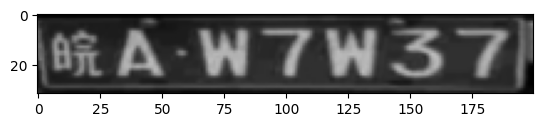

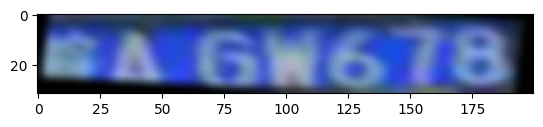

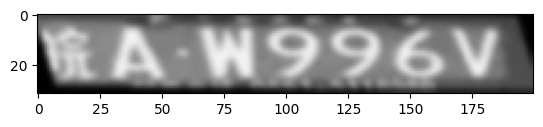

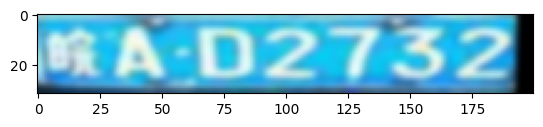

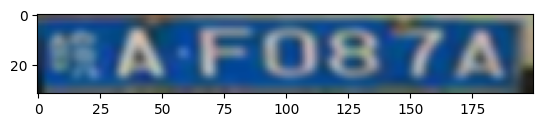

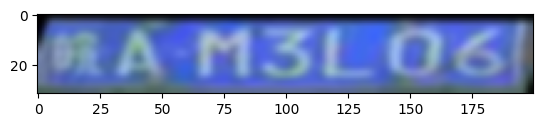

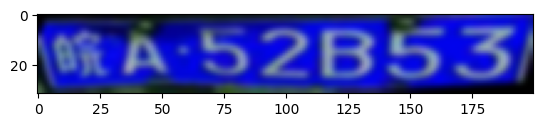

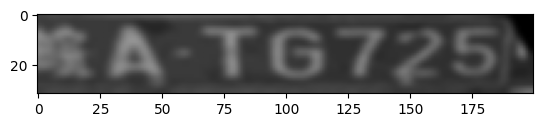

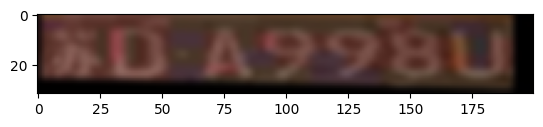

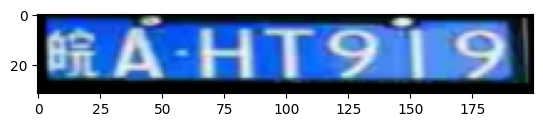

In [11]:
for i in range(10):
    plt.imshow(train_dataset[i][0].permute(1, 2, 0))
    plt.show()

# Нейронная сеть

In [12]:
class CustomConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=1,use_batchnorm=True):
        super().__init__()
        
        if use_batchnorm:
            self.core=nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
        else:
            self.core=nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.ReLU()
            )
        
    def forward(self, x):
        return self.core(x)

In [13]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            CustomConvBlock(in_channels=3, out_channels=64, kernel_size=3, stride=1, use_batchnorm=False),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            CustomConvBlock(in_channels=64, out_channels=128, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size = (1,2), stride = 2),
            CustomConvBlock(in_channels=128, out_channels=256, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size = (1,2), stride = 2),
            CustomConvBlock(in_channels=256, out_channels=128, kernel_size=3, stride=1),
        )
        
    def forward(self, inputs):
        x = self.layers(inputs)
        return x

In [14]:
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout = 0.1):
        super().__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, dropout = dropout, batch_first = True, bidirectional = True)
        
    def forward(self, inputs):
        x, _ = self.rnn(inputs)
        return x

In [15]:
class ConvLSTM(nn.Module):
    def __init__(self, output_dim,  hidden_dim, max_len = 15, num_layers = 2):
        super().__init__()
        self.encoder = Encoder()
        
        self.avg_pool = nn.AdaptiveAvgPool2d((max_len, max_len))
        
        self.rnn = BiLSTM(max_len, hidden_dim, num_layers)
        
        self.classify_layer = nn.Sequential(
            nn.Linear(hidden_dim * 2, max_len),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(max_len, output_dim)
        )
    
    def forward(self, inputs):
        outp = self.encoder(inputs)
        b, c, h, w = outp.shape
        outp = outp.view(b, c * h, w)
        
        outp = self.avg_pool(outp)
        outp = outp.transpose(1,2)
        outp = self.rnn(outp)
        outp = self.classify_layer(outp)
        
        outp = outp.permute(1, 0, 2)
        outp = nn.functional.log_softmax(outp, dim=2)
        
        return outp

# Циклы обучения  и валидации

In [16]:
def collate_fn(batch):
    images, labels, encoded_labels = zip(*batch)
    images = torch.stack(images, 0)
    encoded_labels = torch.nn.utils.rnn.pad_sequence(torch.tensor(encoded_labels), batch_first=True, padding_value=1)
    
    return images, labels, encoded_labels

In [17]:
def train_epoch(model,
               dataset,
               loss_f,
               optimizer,
               scheduler,
               device:str = 'cuda'):
    model.train()
    
    preds = []
    real = []
    
    epoch_loss = 0
        
    for img, label, encoded_label in tqdm(dataset):
        batch = img.shape[0]
        
        img = img.to(device)
        
        optimizer.zero_grad()
        
        preds = model(img)
        
        p_labels = torch.full(size = (batch, ), fill_value = preds.size(0), dtype = torch.long)
        t_labels = torch.full(size = (batch, ), fill_value = encoded_label.size(1), dtype = torch.long)

        loss = loss_f(preds, encoded_label, p_labels, t_labels)
        
        epoch_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    
    return epoch_loss / len(dataset)

In [18]:
def eval_epoch(model,
               dataset,
               loss_f,
               device:str = 'cuda'):
    model.eval()
    
    preds = []
    real = []
    
    epoch_loss = 0
    
    for img, label, encoded_label in tqdm(dataset):
        with torch.no_grad():
            batch = img.shape[0]

            img = img.to(device)
            encoded_label = encoded_label.to(device)

            preds = model(img)

            p_labels = torch.full(size = (batch,), fill_value = preds.size(0), dtype = torch.long)
            t_labels = torch.full(size = (batch,), fill_value = encoded_label.size(1), dtype = torch.long)

            loss = loss_f(preds, encoded_label, p_labels, t_labels)

            epoch_loss += loss.item()
    
    return epoch_loss / len(dataset)

In [19]:
def train_model(model, 
                train_dataset,
                test_dataset,
                batch_size,
                epochs,
                loss_function,
                optimizer,
                scheduler,
                device:str = 'cuda'):
    
    model.to(device)
    loss_function.to(device)
    
    shutil.rmtree("ocr_models")
    os.mkdir("ocr_models")
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, collate_fn = collate_fn)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn = collate_fn)
    
    train_losses = []
    test_losses = []
    
    for epoch_i in range(epochs):
        print('------------------------')
        print(f'Epoch: {epoch_i}')
        
        train_loss = train_epoch(model, train_dataloader, loss_function, optimizer, scheduler, device)
        test_loss = eval_epoch(model, test_dataloader, loss_function, device)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        scheduler.step(test_loss)
        
        torch.save(model, f'ocr_models/model_{epoch_i}.pt') 
        
        print(f'Train loss: {train_loss}')
        print(f'Eval loss: {test_loss}')
    
    return train_losses, test_losses
        

# Обучение

In [20]:
model = ConvLSTM(max_len=15, hidden_dim = 512, output_dim = len(train_dataset.tokenizer), num_layers = 2) 

loss_f =  nn.CTCLoss(blank = 1, reduction = 'mean', zero_infinity = True)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=5, verbose=True) 

In [21]:
import gc 
torch.cuda.empty_cache()
gc.collect()

15455

In [22]:
train_losses, test_losses = train_model(
    model = model,
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    batch_size = 128,
    loss_function = loss_f,
    optimizer = optimizer,
    scheduler = scheduler,
    epochs = 20,
    device = torch.device('cuda')
)

------------------------
Epoch: 0


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 2.741396553914515
Eval loss: 1.597219925892504
------------------------
Epoch: 1


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.7813086475383297
Eval loss: 0.2882023316018189
------------------------
Epoch: 2


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.2117975278640129
Eval loss: 0.1282968835174283
------------------------
Epoch: 3


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.10272356806297907
Eval loss: 0.1049635105212278
------------------------
Epoch: 4


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.0693391346785592
Eval loss: 0.08122838866201383
------------------------
Epoch: 5


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.05387916985210401
Eval loss: 0.07779016537898326
------------------------
Epoch: 6


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.0448920220274881
Eval loss: 0.0689164517164419
------------------------
Epoch: 7


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.03872372126903907
Eval loss: 0.06297558789506932
------------------------
Epoch: 8


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.03391921465771937
Eval loss: 0.052039096167287496
------------------------
Epoch: 9


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.030383676741574907
Eval loss: 0.05532803090548591
------------------------
Epoch: 10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.02759864636424569
Eval loss: 0.04835443762779425
------------------------
Epoch: 11


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.02516656484864819
Eval loss: 0.05077379500740974
------------------------
Epoch: 12


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.023312023695157894
Eval loss: 0.05415641487269556
------------------------
Epoch: 13


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.02209595432808898
Eval loss: 0.04732002728158915
------------------------
Epoch: 14


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.02068905641937954
Eval loss: 0.051929922018471304
------------------------
Epoch: 15


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.01937279510159839
Eval loss: 0.04520325530416191
------------------------
Epoch: 16


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.01813809836333378
Eval loss: 0.044722329641698234
------------------------
Epoch: 17


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.017619548617818667
Eval loss: 0.04687378603723372
------------------------
Epoch: 18


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.016851770519073373
Eval loss: 0.05082805527822126
------------------------
Epoch: 19


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.0161042629324927
Eval loss: 0.04339617561059709


In [25]:
import pandas as pd
import plotly.express as px

df = pd.DataFrame(
    data={
        "epoch": [i for i in range(20)] * 2,
        "loss": train_losses + test_losses,
        "train/val": ["train"] * 20 + ["test"] * 20
    }
)
fig = px.line(df, x="epoch", y="loss", title='График Обучени', color="train/val")
fig.show()

In [26]:
def get_image_text(model, dataset, tokenizer, device = 'cuda'):
    model.eval()
    model.to(device)
    
    preds = []
    real = []
    
    test_dataloader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = False, collate_fn = collate_fn)
    for img, label, encoded_label in tqdm(test_dataloader):
        
        with torch.no_grad():
            batch = img.shape[0]

            img = img.to(device)
            encoded_label = encoded_label.to(device)

            pred = model(img)

            preds.append(tokenizer.decode(pred.argmax(2).squeeze(1).tolist()))
            real.append(label[0])
    
    return preds, real

In [27]:
model = torch.load('ocr_models/model_19.pt')

In [28]:
tokenizer.decode(model(test_dataset[0][0].unsqueeze(0).to('cuda')).argmax(2).squeeze(1).tolist())

'皖AT1R10'

# Скор на трейне

In [29]:
preds, real_labels = get_image_text(model, train_dataset, tokenizer)

  0%|          | 0/199980 [00:00<?, ?it/s]

In [30]:
accuracy = torchmetrics.CharErrorRate()

In [31]:
accuracy(preds, real_labels) / 100

tensor(8.3223e-06)

In [32]:
accuracy_score(preds, real_labels)

0.9943344334433444

# Скор на тесте

In [33]:
test_preds, test_real_labels = get_image_text(model, test_dataset, tokenizer)

  0%|          | 0/9999 [00:00<?, ?it/s]

In [34]:
accuracy = torchmetrics.CharErrorRate()

In [35]:
accuracy(test_preds, test_real_labels) / 100

tensor(7.3865e-05)

In [36]:
accuracy_score(test_preds, test_real_labels)

0.9603960396039604

# Анализ ошибок модели

In [43]:
error_indexes = [i for i in range(len(test_preds)) if test_preds[i] != test_real_labels[i]]
correct_indexes = [i for i in range(len(test_preds)) if test_preds[i] == test_real_labels[i]]

С ходу мжно предположить, что модели было сложно справитьс с плохимми зображеними на которых есть блюр, где загорожен номер, или же где номер испорчен.

Давайте проверим гипотезу:

Изображения с наибольшим CER:

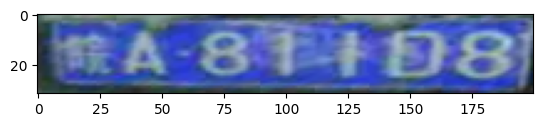

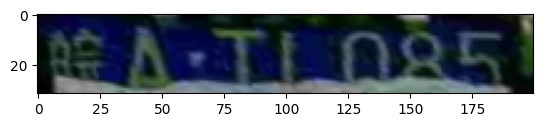

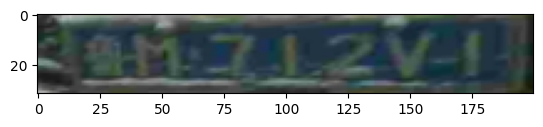

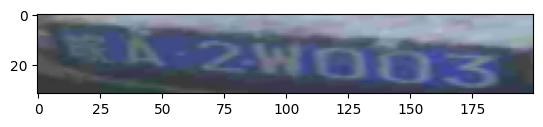

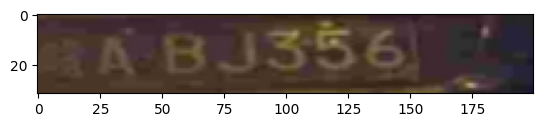

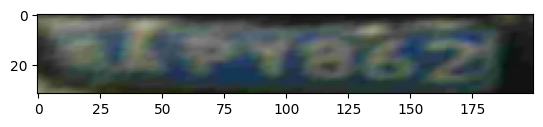

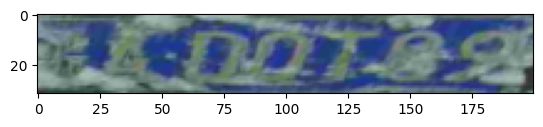

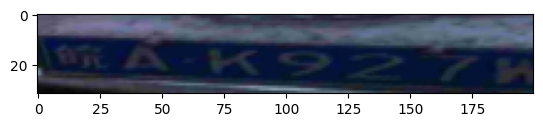

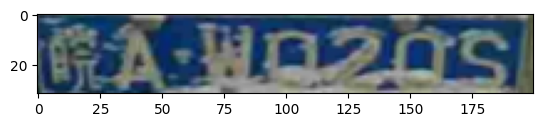

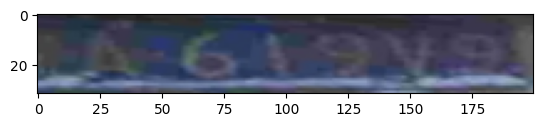

In [51]:
cer_losses = np.array([accuracy(test_preds[i], test_real_labels[i]) for i in range(len(test_preds))])
img_ids = np.argpartition(cer_losses, -10)[-10:]
for i in img_ids:
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.show()

Неправильно классифицированные изображеня:

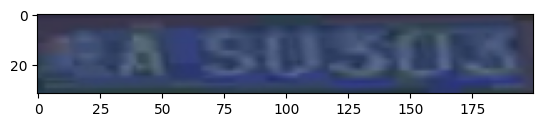

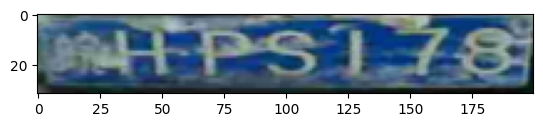

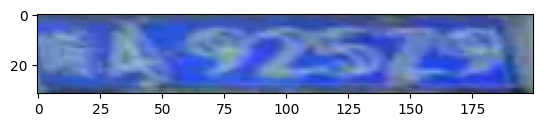

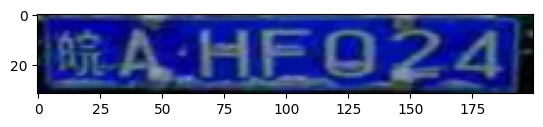

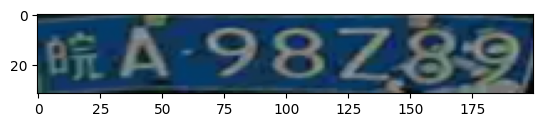

In [53]:
import matplotlib.pyplot as plt
for i in range(5):
    plt.imshow(test_dataset[error_indexes[i]][0].permute(1, 2, 0))
    plt.show()

Правильно классифицированные изображения:

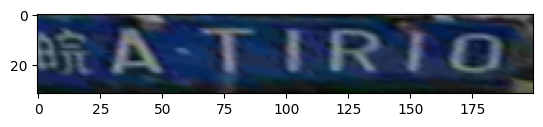

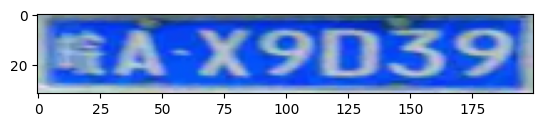

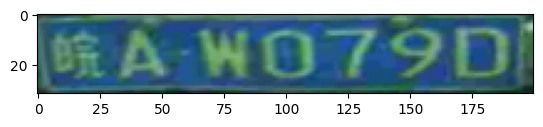

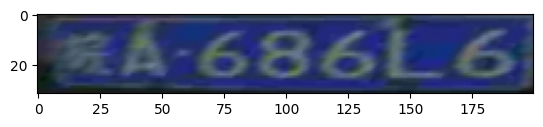

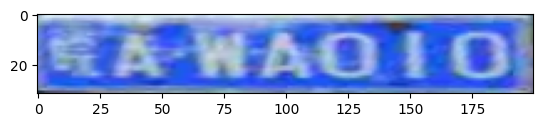

In [45]:
for i in range(5):
    plt.imshow(test_dataset[correct_indexes[i]][0].permute(1, 2, 0))
    plt.show()

Можем заметить, что гепотиа верна и нашей сетке действительно сложнее раюотать с более темными, заблюринными и стёртыми номерными знаками

# Confusion Matrix

In [46]:
all_test_preds = []
all_test_real_labels = []

for i in tqdm(range(len(test_preds))):
    pred_chars = list(test_preds[i])
    true_chars = list(test_real_labels[i])
    
    pred_len = len(pred_chars)
    true_len = len(true_chars)
    
    if pred_len > true_len:
        pred_chars = pred_chars[:true_len]
    
    elif pred_len < true_len:
        pred_chars = pred_chars + ["<BLANK>"] * (true_len - pred_len)
        
    all_test_preds.extend(pred_chars)
    all_test_real_labels.extend(true_chars)


  0%|          | 0/9999 [00:00<?, ?it/s]

<AxesSubplot: >

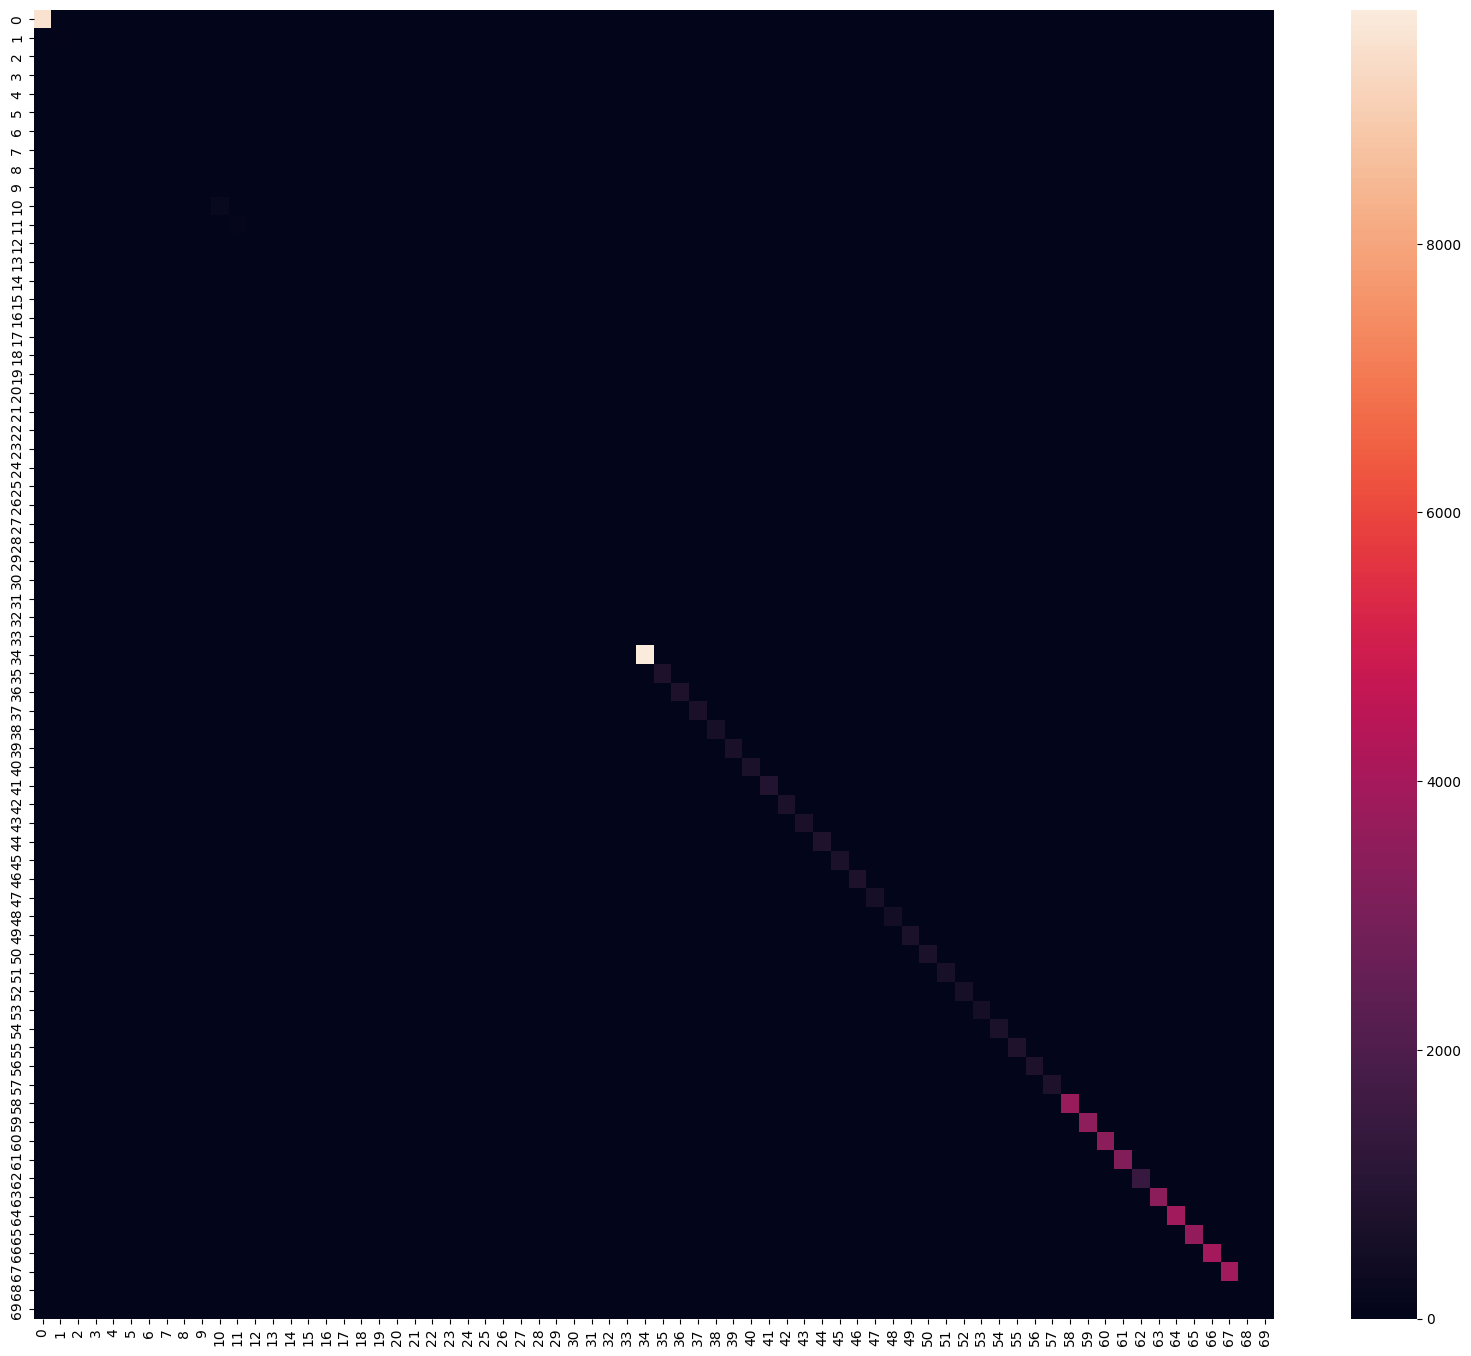

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(20,17))
sns.heatmap(confusion_matrix(all_test_real_labels, all_test_preds, labels=vocab + ["<BLANK>"]))

По матрице ошибок видим, что наша сеть совсем незначительно путает классы (по крайней мере ошибок не видно на дисаграмме)

# Вывод

1. Аугментации по типу блюра, изменени цвета и яркости сильно помогают моделе

Что можнно улучшить:
1. Другой feature extractor, например VIT
2. Подавать нескоько вреймов в СТС Loss